This builds on TESQ-ml-ns-nogo-go

> **proposal 1**
> 
> Two class (e.g., CorrectStop vs. CorrectGo)
> 
> Leave-One-Out classifier...
> 
> Neural similarity of a subject to the group with a Stop vs. Go contrast might actually be indicative of performance.
> 
> subjects will naturally differ across the task as to how much their average signal responds to that, and the ones with better response might have better response inhibition.

We use the same neural data, but instead of regressing on classifying these classes, we take one class or the other or we combine them in some way and we regress on our self report variables.

So there are a couple of steps here...

1. iterate through subjects, holding out one at a time, and do the following steps.
2. Train a regressor across all the training subjects, regressing CorrectStop and CorrectGo on TESQ-E and other self report measures including FFQ either (a) independently (b) contrasted with each other (c) concatenated in a single image.
3. If a link can be established, we've shown there is a relevant link between TESQ-E or other self-report measure, and the neural signature.
4. ...that seems like a publication in itself!




As a first pass, we can simplify this a bit just trying that single classifier on all subjects. This means that we're using train for tes tset but it will give us an initial measure of feasibility.

We probably do need to restrict to a specific brain region though, and that means retraining. - I think that prefrontal cortex mask we have works well.

## Data already generated

Can we use data already generated in `SST_inhibition_cv.ipynb`?

In [1]:
import pickle
from IPython.core.display import display, HTML, Markdown

In [2]:
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [3]:
#results_filepath=ml_data_folderpath + "/SST/train_test_results_conditions_40subs_twoclasses.pkl"

In [4]:
#results_2c = pickle.load(open(results_filepath,'rb'))

In [5]:
from nilearn import plotting
from nilearn.masking import compute_brain_mask
import nltools as nlt

#plotting.view_img(results_2c[3]['CorrectGo'],threshold=0.0002)

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [6]:
#plotting.plot_glass_brain(results_2c[3]['CorrectGo'])

In [7]:
#plotting.view_img(results_2c[3]['CorrectStop'],cmap='blue_red')

In [8]:
background_img = nlt.Brain_Data('/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain.nii').to_nifti()

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


Not quite--we need a PFC mask I think. But we can use the script already written to do that.

## Setup

In [9]:
import sys
import os
import pandas as pd

sys.path.append(os.path.abspath("../../ml/"))

from apply_loocv_and_save import *
from dev_wtp_io_utils import *
import gc
import nibabel as nib

from os import path



python initialized for apply_loocv_and_save
cpus available; cpus to use:
28 25
28


In [10]:
from analyze_results import *

## condition_contrast

In [11]:
#load the matrix associated with this file
sl_mat = scipy.io.loadmat(
'/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV073/SPM.mat',
simplify_cells=True            
)
mat_betas = sl_mat['SPM']['Vbeta']

In [12]:
[mat_betas[beta_i]['descrip'] for beta_i in range(len(mat_betas))]

['spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)',
 'spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)',
 'spm_spm:beta (0003) - Sn(1) FailedStop*bf(1)',
 'spm_spm:beta (0004) - Sn(1) Cue*bf(1)',
 'spm_spm:beta (0005) - Sn(1) R1',
 'spm_spm:beta (0006) - Sn(1) R2',
 'spm_spm:beta (0007) - Sn(1) R3',
 'spm_spm:beta (0008) - Sn(1) R4',
 'spm_spm:beta (0009) - Sn(1) R5',
 'spm_spm:beta (0010) - Sn(1) constant']

## stitching contrasts together in different ways

We'd want:

 - contrast of the two conditions
 - each of the two conditions alone.
 
The contrast is a little tricky. Easiest thing is to try each of the conditions alone. Stitching the two together might not be too hard. Let's try doing CorrectStop first, and then we'll try concatenating the images. Doing a contrast is actually the most difficult becuase I have to backtrack in the process to generate new betas (see https://docs.google.com/presentation/d/1K-nFrZYE6rR8t0myNyacB7frBzV3B1--nMqPhVkwL8E/edit#slide=id.geeff6890fb_0_16).

See `different ways of combining images.ipynb`.

## template

## regressing on self report

In [13]:
nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20210601T183243.csv"
test_train_df = pd.read_csv(train_test_markers_filepath)

all_sst_events= pd.read_csv(ml_data_folderpath +"/SST/" + "all_sst_events.csv")


dataset_name = 'conditions'

from nilearn.decoding import DecoderRegressor, Decoder

script_path = '/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml'
# HRF 2s

#get a PFC mask
#pfc_mask = create_mask_from_images(get_pfc_image_filepaths(ml_data_folderpath + "/"),threshold=10)

In [14]:
def sr_regressor_trans_func(X):
#         print(X.columns)
#         print(X[self_report_regression_var])
    return(X[self_report_regression_var])

def decoderConstructor(*args, **kwargs):
    return(DecoderRegressor(scoring='neg_mean_absolute_error',verbose=0, *args, **kwargs))

    
def do_complete_sr_regression_analysis_for_mask(
    self_report_regression_var,
    mask_filepath,
    mask_threshold,
    results_filepath,
    source_dataset_relpath
):
    mask_filename = os.path.basename(mask_filepath)
    mask_name = mask_filename.split(".")[0]

    display(Markdown("## " + mask_name))
    mask_img = create_mask_from_images([mask_filepath],threshold=mask_threshold)
    
    dataset_name = 'conditions'
    
    brain_data_filepath = ml_data_folderpath + source_dataset_relpath
    #brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

    if path.exists(results_filepath) is False:
        apply_loocv_and_save(
            results_filepath = results_filepath,
            brain_data_filepath = brain_data_filepath,
            train_test_markers_filepath = train_test_markers_filepath,
#            subjs_to_use = 20,
            decoderConstructor = decoderConstructor,
            response_transform_func=sr_regressor_trans_func,
            mask=mask_img
        )
    print(results_filepath)
    results=pickle.load(open(results_filepath,'rb'))


    visualize_series_corr(results[2]['y'],results[2]['y_pred'])

    return(results)


In [15]:
from analyze_results import *

In [16]:

data_by_ppt_name = "data_by_ppt_2021_12_29.csv"


individual_differences = pd.read_csv(ml_data_folderpath + "/"+ data_by_ppt_name)
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

", ".join(individual_differences.columns)

'subject, cancer_promoting_minus_preventing_FCI, cancer_promoting_minus_preventing_FFQ, cancer_promoting_minus_preventing_craved_FCI, cancer_promoting_minus_preventing_craved_FFQ, cancer_promoting_minus_preventing_liked_FCI, cancer_promoting_minus_preventing_liked_FFQ, cancer_promoting_FCI, cancer_promoting_FFQ, cancer_preventing_FCI, cancer_preventing_FFQ, BSCS, cSES, EDM, BIS_11, PCS, RS, TRSQ, bf_1, weight_0, height_0, birthsex, age365, bmi_0, bmi_1, bmi, bf_1_controlled, bf_1_bsexnormedzs, ACES_sum, ACES_household_dysfunction, ACES_neglectful_parenting, ACES_abuse, ACES_divorced_separated, BFI_agreeableness, BFI_conscientiousness, BFI_extraversion, BFI_neuroticism, BFI_openness, DEMO_mcarthur_social_standing, IMI_effort_importance, IMI_interest_enjoyment, IMI_perceived_choice, IMI_perceived_competence, IMI_value_usefulness, IPAQ_moderateminutes, IPAQ_sittinghours, IPAQ_vigorousminutes, IPAQ_walkingminutes, NCS_get_job_done, NCS_deliberating_issues, NCS_prefer_complex, NCS_prefer_li

In [17]:
harvox_folderpath = ml_data_folderpath + "/masks/response_inhibition_related/harvardoxford/"
neurosynth_folderpath = ml_data_folderpath + "/masks/response_inhibition_related/"



def get_mask_df(mask_folder,mask_threshold):
    mask_name_list = os.listdir(mask_folder)
    mask_dict_list = []
    for mask_filename in mask_name_list:
        mask_filepath = mask_folder + mask_filename
        if os.path.isdir(mask_filepath):
            continue # this is a directory, don't process it.
            
        mask_dict_list = mask_dict_list + [
            {'name':mask_filename.split(".")[0],
                'filename' : mask_filename,
             'filepath' : mask_filepath,
             'threshold': mask_threshold
            }]
    return(pd.DataFrame(mask_dict_list))

mask_list = pd.concat([get_mask_df(harvox_folderpath,30),
          get_mask_df(neurosynth_folderpath,0)])


harvardoxford-cortical_prob_Superior Frontal Gyrus.nii.gz


## harvardoxford-cortical_prob_Superior Frontal Gyrus

checked for intersection and no intersection between the brain data and the subjects was found.
there were 58 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 166
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
clean: 60
Brain_Data_allsubs: 48
subjs_to_use: 16
78
84


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


starting LeaveOneOut
finished preprocessing
Groups are the same.
fold 1 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV105']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -15.028555041795855
fold 2 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV058']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -3.973668679722337
fold 3 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV074']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -0.665794155027676
fold 4 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV197']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -9.32767702790894
fold 5 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV027']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -21.161160845151898
fold 6 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV049']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -3.288405367273832
fold 7 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV026']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -9.602728738982748
fold 8 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV052']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -20.8879655172099
fold 9 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV173']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -4.999689315348029
fold 10 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV087']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -4.94229143360856
fold 11 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV042']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -13.132474947034773
fold 12 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV186']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -1.9206125365551543
fold 13 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV062']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -5.442242701179772
fold 14 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV053']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -13.523597209878076
fold 15 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV055']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -14.813105044381786
fold 16 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV018']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -10.28999899837524
fold 17 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV073']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -4.091966593205349
fold 18 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV076']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -18.976563048309423
fold 19 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV085']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -8.353370664641055
fold 20 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV169']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -11.170417889776793
fold 21 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV059']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -9.92680849715942
fold 22 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV013']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -7.53781432865658
fold 23 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV029']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -13.48414075833206
fold 24 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV215']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -17.070005958480834
fold 25 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV157']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -2.6317991517150148
fold 26 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV141']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -18.978256740528266
fold 27 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV051']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -19.574172382468774
fold 28 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV135']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -3.738643482836501
fold 29 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV097']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -5.953194905678515
fold 30 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV017']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -13.43929021142884
fold 31 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV035']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -6.974383371670903
fold 32 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV009']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -1.4086055541761198
fold 33 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV047']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -2.716294213670679
fold 34 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV206']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -3.372045661010958
fold 35 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV006']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -9.919273926340495
fold 36 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV022']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -10.662638975739668
fold 37 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV040']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -5.215205932152628
fold 38 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV079']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -3.3912534443490756
fold 39 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV084']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -5.347243994948855
fold 40 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV021']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -14.405427916459693
fold 41 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV015']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -7.306375203792392
fold 42 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV071']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -0.0051236062647177505
fold 43 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV060']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -7.249819542307549
fold 44 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV005']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -9.191037614999452
fold 45 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV025']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -31.445228109500633
fold 46 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV039']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -24.50241607126391
fold 47 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV086']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -12.667768126982565
fold 48 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV069']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -8.569522122044653
fold 49 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV159']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -0.02745319250657019
fold 50 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV011']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -15.123957676821128
fold 51 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV107']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -10.80999068194052
fold 52 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV014']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -12.438445617818829
fold 53 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV057']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -8.133748500466105
fold 54 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV050']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -6.510309648155065
fold 55 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV024']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -1.865803666778966
fold 56 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV036']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -35.32199602677322
fold 57 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV056']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -34.16534394216755
fold 58 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV145']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -31.021415001342675
fold 59 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV067']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -8.610188870611111
fold 60 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV023']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -0.2658966383458008
fold 61 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV020']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -33.80309769086945
fold 62 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV164']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -2.639389960050991
fold 63 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV216']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -3.243210828672531
fold 64 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV046']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -20.042900610172076
fold 65 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV083']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -21.822200216654664
fold 66 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV064']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -4.679505554678059
fold 67 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV048']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -20.43394513423374
fold 68 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV217']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -2.0364430646083065
fold 69 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV028']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -4.991505457421908
fold 70 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV010']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -15.107228726918557
fold 71 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV068']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -17.339703471550727
fold 72 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV019']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -20.797050303728966
fold 73 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV158']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -9.81305592876538
fold 74 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV043']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -20.897000217409726
fold 75 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV171']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -19.727086132293238
fold 76 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV012']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -0.26370420408078843
fold 77 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV041']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -22.10529689373299
fold 78 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV077']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


test score was:. -10.686863248330958
-15.028555041795855
-15.028555041795855
running one more time on whole dataset for beta map
finished learning
saved.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_sum/correct_go/regress_sr_TESQ_E_sum_84subs_harvardoxford-cortical_prob_Superior Frontal Gyrus.pkl


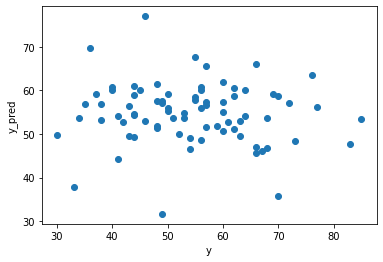

harvardoxford-cortical_prob_Frontal Pole.nii.gz


## harvardoxford-cortical_prob_Frontal Pole

checked for intersection and no intersection between the brain data and the subjects was found.
there were 58 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 166
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
clean: 60
Brain_Data_allsubs: 48
subjs_to_use: 16
78
84


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


starting LeaveOneOut
finished preprocessing
Groups are the same.
fold 1 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV105']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -12.17793085606526
fold 2 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV058']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -3.7003177387036956
fold 3 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV074']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -6.4450521650881285
fold 4 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV197']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/signal.py:58: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


test score was:. -7.532072158445764
fold 5 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV027']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


KeyboardInterrupt: 

In [67]:

for self_report_regression_var in ['TESQ_E_sum', 'TESQ_E_distraction','TESQ_E_suppression']:
    regression_output_folderpath = ml_data_folderpath + "/SST/regress_sr_" + self_report_regression_var
    if os.path.exists(regression_output_folderpath)==False:
        os.mkdir(regression_output_folderpath)
    for source_dataset_name in ['correct_go','correct_stop']:
        source_output_folderpath = regression_output_folderpath + "/" + source_dataset_name
        if os.path.exists(source_output_folderpath)==False:
            os.mkdir(source_output_folderpath)
        for mlr_i, mlr in mask_list.iterrows():
            print(mlr['filename'])
            results_filepath=(
                source_output_folderpath + 
                "/regress_sr_" + self_report_regression_var + "_84subs_" + 
                mlr['name'] + ".pkl"
            )
            do_complete_sr_regression_analysis_for_mask(
                self_report_regression_var = self_report_regression_var,
                mask_filepath = mlr['filepath'],
                mask_threshold = mlr['threshold'],
                results_filepath = results_filepath,
                source_dataset_relpath = '/SST/Brain_Data_conditions_84subs_' + source_dataset_name + '_w_supplementary.pkl'
            )
            

In [36]:
def visualize_series_corr(series1,series2):
    display(HTML(series1.name + " vs " + series2.name))
    pearson_result = pearsonr(series1,series2)
    display(HTML("r=" + format(pearson_result[0],".2f") +"; p-value=" + format(pearson_result[1],".4f")))
    spearman_result = spearmanr(series1,series2)
    display(HTML("rho=" + format(spearman_result[0],".2f") +"; p-value=" + format(spearman_result[1],".4f")))
    cplot = pyplot.scatter(series1,series2)
    cplot.axes.set_xlabel(series1.name)
    cplot.axes.set_ylabel(series2.name)
    pyplot.show()

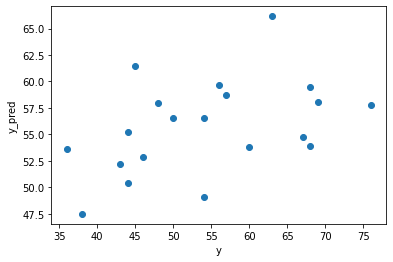

In [37]:
from matplotlib import pyplot as plt

## generate commands to run the batch version of the above

In [70]:


for self_report_regression_var in ['TESQ_E_sum', 'TESQ_E_distraction','TESQ_E_suppression']:
    regression_output_folderpath = ml_data_folderpath + "/SST/regress_sr_" + self_report_regression_var
    if os.path.exists(regression_output_folderpath)==False:
        os.mkdir(regression_output_folderpath)
    for source_dataset_name in ['correct_go','correct_stop']:
        source_output_folderpath = regression_output_folderpath + "/" + source_dataset_name
        if os.path.exists(source_output_folderpath)==False:
            os.mkdir(source_output_folderpath)
        for mlr_i, mlr in mask_list.iterrows():
            #print(mlr['filename'])
            results_filepath=(
                source_output_folderpath + 
                "/regress_sr_" + self_report_regression_var + "_84subs_" + 
                mlr['name'] + ".pkl"
            )
            print("sbatch run_sr_learning_script.sbatch ml-ns_on_self_report_batch.py" + 
                  " -m \"" + mlr['filepath'] + "\"" + 
                  " -t " + str(mlr['threshold']) + 
                  " -r " + self_report_regression_var + 
                  " -s " + '/SST/Brain_Data_conditions_84subs_' + source_dataset_name + '_w_supplementary.pkl' +
                  " -o \"" + results_filepath + "\"")
        
#             do_complete_sr_regression_analysis_for_mask(
#                 self_report_regression_var = self_report_regression_var,
#                 mask_filepath = mlr['filepath'],
#                 mask_threshold = mlr['threshold'],
#                 results_filepath = results_filepath,
#                 source_dataset_relpath = '/SST/Brain_Data_conditions_84subs_' + source_dataset_name + '_w_supplementary.pkl'
#             )
         

sbatch run_sr_learning_script.sbatch ml-ns_on_self_report_batch.py -m "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/masks/response_inhibition_related/harvardoxford/harvardoxford-cortical_prob_Superior Frontal Gyrus.nii.gz" -t 30 -r TESQ_E_sum -s /gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/Brain_Data_conditions_84subs_correct_go_w_supplementary.pkl -o "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_sum/correct_go/regress_sr_TESQ_E_sum_84subs_harvardoxford-cortical_prob_Superior Frontal Gyrus.pkl"
sbatch run_sr_learning_script.sbatch ml-ns_on_self_report_batch.py -m "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/masks/response_inhibition_related/harvardoxford/harvardoxford-cortical_prob_Frontal Pole.nii.gz" -t 30 -r TESQ_E_sum -s /gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/Brain_Data_conditions_84subs_correct_go_w_supplementary.pkl -o "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_sum/

## Using the concatenated image version

So I wrote some code to concatenate two different images. This will allow us to train a learner that reads off both CorrectGo and CorrectStop, _separately_, and then pick the best voxels across the group for prediction.

Let's create new input files at the previous step, at `load_multisubject_brain_data_ssw_w1-conditions.ipynb`. Then we can just input the revised data and run it as its own file.